# Word Embeddings and Gender Bias


**Description:** In this Jupyter notebook, we will load some pretrained word embeddings (FastText in our case), and see the gender bias that they implicitly learn, by some analogy tasks, algorithms and visualization tools. By Gorka Urbizu.

Import external functions and packages

In [0]:
import cython #ENSURE cython package is installed on computer/canopy
from gensim.models import phrases 
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from statistics import mean
from gensim.models import Word2Vec, FastText, KeyedVectors
import pandas as pd
from string import ascii_letters, digits
from sklearn.manifold import TSNE
%matplotlib inline
import random
import numpy as np
from matplotlib import pyplot as plt

#if you don't have any of these libraries, you will need to install them first with conda install or pip install

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Load up a pretrained Word2Vec Model:**



In [0]:
path='drive/My Drive/Colab Notebooks/genderBiasEmb/'
eu = path+"eu300.vec"
euEmb = KeyedVectors.load_word2vec_format(eu, binary=False)

en = path+"en300.vec"
enEmb = KeyedVectors.load_word2vec_format(en, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


How many vocabulary words includes the embeddings? 

In [0]:
print("Eu vocab: "+str(len(euEmb.vocab))) 
print("En vocab: "+str(len(enEmb.vocab))) 

Eu vocab: 100000
En vocab: 100000


Let's look at the raw word-vector for 'neska' and 'girl'. These numbers aren't so meaninful to human readers on their own. 

In [0]:
euEmb['neska']
enEmb['girl']

array([ 1.328e-01, -5.160e-02,  1.420e-02,  7.710e-02, -6.100e-02,
       -7.640e-02,  5.760e-02,  9.000e-04, -1.660e-02,  6.360e-02,
       -4.190e-02, -4.150e-02, -3.990e-02, -3.180e-02, -6.660e-02,
        7.770e-02, -1.335e-01,  1.400e-03, -4.000e-04,  8.070e-02,
        5.140e-02,  2.700e-02, -5.700e-03,  3.310e-02, -3.190e-02,
        3.020e-02, -3.170e-02, -3.900e-02,  3.070e-02,  1.118e-01,
       -1.680e-02,  7.250e-02,  1.037e-01, -1.090e-02, -4.930e-02,
        5.190e-02,  3.000e-03, -7.440e-02,  2.320e-02, -5.200e-02,
       -3.290e-02,  3.910e-02, -2.640e-02,  2.560e-02, -7.960e-02,
       -2.670e-02,  6.230e-02, -3.720e-02, -4.660e-02, -4.180e-02,
        5.550e-02,  2.200e-03,  1.140e-02,  3.660e-02,  3.230e-02,
        6.790e-02,  7.760e-02,  2.300e-03, -6.700e-03, -5.560e-02,
        1.900e-02, -5.760e-02, -1.510e-02,  1.410e-02,  4.120e-02,
       -5.980e-02,  6.990e-02,  3.380e-02, -3.650e-02, -5.400e-03,
       -5.650e-02,  8.000e-04, -1.013e-01, -4.820e-02, -8.660e

Calculate cosine similarity of two words specifically

In [0]:
print(1 - spatial.distance.cosine(enEmb['she'], enEmb['nurse'])) 
print(1 - spatial.distance.cosine(enEmb['he'], enEmb['nurse']))
print(1 - spatial.distance.cosine(enEmb['she'], enEmb['teacher'])) 
print(1 - spatial.distance.cosine(enEmb['he'], enEmb['teacher']))
print(1 - spatial.distance.cosine(enEmb['she'], enEmb['banker'])) 
print(1 - spatial.distance.cosine(enEmb['he'], enEmb['banker']))

0.3786236643791199
0.1488347202539444
0.3325585424900055
0.22982299327850342
0.20083698630332947
0.28296926617622375


## Calculate and visualize gender bias

For English Embeddings

In [0]:
def get_gender_bias(vectors, word, male_voc, fem_voc):
  sim = 0
  l = min(len(male_voc),len(female_voc))
  for i in range(l):
    simM = (1 - spatial.distance.cosine(vectors[word], vectors[male_voc[i]]))
    simF = (1 - spatial.distance.cosine(vectors[word], vectors[female_voc[i]]))
    sim += -simM+simF
  return sim/l
  m = get_avg_sim(vectors, word, male_voc)
  f = get_avg_sim(vectors, word, female_voc)
  return -m+f

[0.10889164507389068, 0.06370590031147003, -0.02488493323326111, -0.015841737389564514, 0.058235999941825864, -0.046096242219209674, 0.03861331343650818, -0.0507536381483078, -0.061407840251922606, -0.03258082121610641]
[5, 7, 3, 9, 8, 6, 2, 4, 0, 2]
10
10


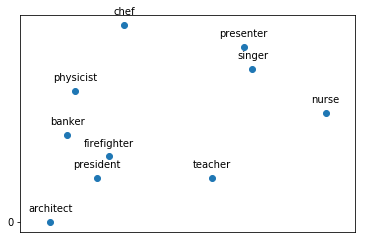

In [0]:
male_voc = ["he", "boy", "son", "father", "brother", "grandfather", "uncle", "husband", "boyfriend", "king"]
female_voc = ["she", "girl", "daughter", "mother", "sister", "grandmother", "aunt", "wife", "girlfriend", "queen"]
jobs = ["nurse", "singer", "firefighter", "chef", "presenter", "physicist", "teacher", "banker", "architect", "president"]
vectors =enEmb
bias_list = []
for job in jobs:
  bias = get_gender_bias(vectors, job, male_voc, female_voc)
  bias_list.append(bias)
print(bias_list)

r = []
for i in range(0,10):
   r.append(random.randint(0,9))
print(r)
print(len(r))
print(len(bias_list))
xs,ys = bias_list,r
plt.scatter(xs,ys)


# zip joins x and y coordinates in pairs
i=0
for x,y in zip(xs,ys):

    label = "{:.2f}".format(y)

    plt.annotate(jobs[i], # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    i+=1

plt.xticks(np.arange(-0.1,0.1,1))
plt.yticks(np.arange(0,10,10))

plt.show()
  

For Basque Embeddings

[0.028234034776687622, 0.0015336915850639344, -0.013194068521261215, -0.022759687900543214, 0.008906985074281693, -0.03495948389172554, 0.004051181674003601, -0.06170732527971268, -0.040559806115925315, -0.05242410339415073]
[3, 2, 2, 7, 3, 3, 7, 0, 9, 3]
10
10


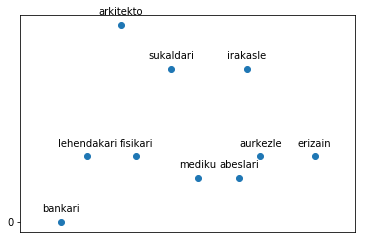

In [0]:
male_voc = ["gizon","mutil", "seme", "aita", "neba", "aitona", "osaba", "senar", "anai", "errege"]
female_voc = ["emakume","neska", "alaba", "ama", "arreba", "amona", "izeba", "emazte", "arreba", "erregina"]
jobs = ["erizain", "abeslari", "mediku", "sukaldari", "aurkezle", "fisikari", "irakasle", "bankari", "arkitekto", "lehendakari"]

vectors =euEmb
bias_list = []
for job in jobs:
  bias = get_gender_bias(vectors, job, male_voc, female_voc)
  bias_list.append(bias)
print(bias_list)

r = []
for i in range(0,10):
   r.append(random.randint(0,9))
print(r)
print(len(r))
print(len(bias_list))
xs,ys = bias_list,r
plt.scatter(xs,ys)


# zip joins x and y coordinates in pairs
i=0
for x,y in zip(xs,ys):

    label = "{:.2f}".format(y)

    plt.annotate(jobs[i], # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    i+=1

plt.xticks(np.arange(-0.1,0.1,1))
plt.yticks(np.arange(0,10,10))

plt.show()